<a href="https://colab.research.google.com/github/mrMichalR/alien_vs_predator/blob/main/alien_vs_predator_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Alien vs Predator - image classification**

In [ ]:
!pip install opendatasets
!pip install gradio
!pip install h5py
!pip install load_img

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement load_img (from versions: none)
ERROR: No matching distribution found for load_img


# Imports / libraries

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
import cv2
import os
import sys
import opendatasets as od
import collections
import torch
import requests
import gradio as gr

from matplotlib.image import imread
from tqdm import tqdm
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils import image_dataset_from_directory, load_img, img_to_array
from PIL import Image
from torchvision import transforms

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images/download?datasetVersionNumber=1'
od.download(dataset_url)

Skipping, found downloaded files in "./alien-vs-predator-images" (use force=True to force download)


# EDA

In [ ]:
BATCH_SIZE = 32
EPOCHS = 2
SEED = 42
IMG_HEIGHT = 200
IMG_WIDHT = 200
TRAIN_PATH = '/content/alien-vs-predator-images/data/train/'
VAL_PATH = '/content/alien-vs-predator-images/data/validation/'

TRAIN_PATH_ALIEN = TRAIN_PATH +'alien/'
TRAIN_PATH_PREDATOR = TRAIN_PATH +'predator/'
alien_val_path = VAL_PATH +'alien/'
predator_val_path = VAL_PATH +'predator/'

In [ ]:
training_dataset = ImageDataGenerator().flow_from_directory(TRAIN_PATH, class_mode='binary',shuffle=True, target_size=(IMG_HEIGHT, IMG_WIDHT))
print(training_dataset.class_indices)
print(f'Alien classes count:{len(sorted(os.listdir(TRAIN_PATH_ALIEN)))}')
print(f'Predator classes count:{len(sorted(os.listdir(TRAIN_PATH_PREDATOR)))}\n')

# validation_dataset = ImageDataGenerator().flow_from_directory(TRAIN_PATH, class_mode='binary', shuffle=True, target_size=(IMG_HEIGHT, IMG_WIDHT))
test_dataset = ImageDataGenerator().flow_from_directory(VAL_PATH, class_mode='binary', shuffle=False)

Found 694 images belonging to 2 classes.
{'alien': 0, 'predator': 1}
Alien classes count:347
Predator classes count:347

Found 200 images belonging to 2 classes.


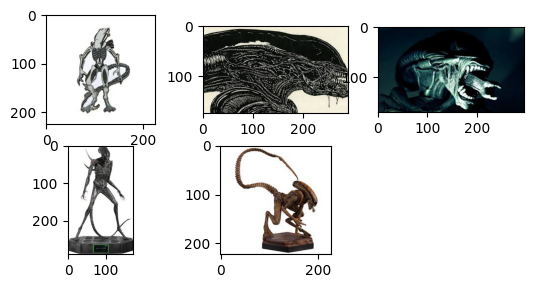

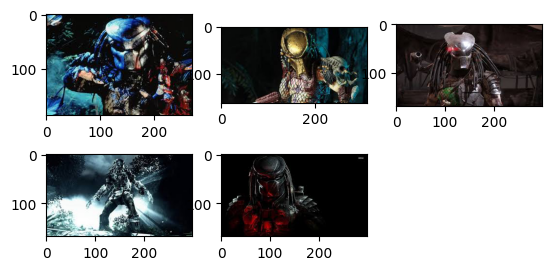

In [ ]:
def plot_sample(folder):
  # plot first few images
  for i in range(5):
    # define subplot
    plt.subplot(330 + 1 + i)
    # define filename
    filename = folder + str(i) + '.jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    plt.imshow(image)
  # show the figure
  plt.show()

plot_sample(TRAIN_PATH_ALIEN)
plot_sample(TRAIN_PATH_PREDATOR)

# Train model

Define model

In [ ]:
# define cnn model
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDHT, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy"])
  return model


# define cnn model with dropout
def define_model_with_dropout():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDHT, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model


# plot diagnostic learning curves
def summarize_diagnostics(history):
  # plot loss
  plt.subplot(211)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='test')
  # plot accuracy
  plt.subplot(212)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='test')
  plt.tight_layout()
  # save plot to file
  filename = sys.argv[0].split('/')[-1]
  plt.savefig(filename + '_plot.png')
  plt.close()

In [ ]:
def run_test_harness_augOFF_dropoutOFF():
  # define model
  model = define_model()
  # create data generators with data augmentation
  train_datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.20)
  # prepare iterators
  train_it = train_datagen.flow_from_directory(TRAIN_PATH, class_mode='binary', batch_size=64, target_size=(IMG_HEIGHT, IMG_WIDHT), subset='training', seed=SEED)
  val_it = train_datagen.flow_from_directory(TRAIN_PATH, class_mode='binary', batch_size=64, target_size=(IMG_HEIGHT, IMG_WIDHT), subset='validation', seed=SEED)
  # fit model
  history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=val_it, validation_steps=len(val_it), epochs=EPOCHS, verbose=0)
  # evaluate model
  _train , acc_train = model.evaluate(train_it, steps=len(train_it), verbose=0)
  _val , acc_val = model.evaluate(val_it, steps=len(val_it), verbose=0)
  print(f'Train: > %.3f' % (acc_train * 100.0))
  print(f'Val: > %.3f' % (acc_val * 100.0))
  # learning curves
  summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness_augOFF_dropoutOFF()

Found 556 images belonging to 2 classes.
Found 138 images belonging to 2 classes.
Train: > 50.540
Val: > 50.000


In [ ]:
def run_test_harness_augOFF_dropoutON():
  # define model
  model = define_model_with_dropout()
  # create data generators with data augmentation
  train_datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.20)
  # prepare iterators
  train_it = train_datagen.flow_from_directory(TRAIN_PATH, class_mode='binary', batch_size=64, target_size=(IMG_HEIGHT, IMG_WIDHT), subset='training', seed=SEED)
  val_it = train_datagen.flow_from_directory(TRAIN_PATH, class_mode='binary', batch_size=64, target_size=(IMG_HEIGHT, IMG_WIDHT), subset='validation', seed=SEED)
  # fit model
  history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=val_it, validation_steps=len(val_it), epochs=EPOCHS, verbose=0)
  # evaluate model
  _train , acc_train = model.evaluate(train_it, steps=len(train_it), verbose=0)
  _val , acc_val = model.evaluate(val_it, steps=len(val_it), verbose=0)
  print(f'Train: > %.3f' % (acc_train * 100.0))
  print(f'Val: > %.3f' % (acc_val * 100.0))
  # learning curves
  summarize_diagnostics(history)


# entry point, run the test harness
run_test_harness_augOFF_dropoutOFF()

Found 556 images belonging to 2 classes.
Found 138 images belonging to 2 classes.
Train: > 52.878
Val: > 52.174


In [ ]:
# run the test harness for evaluating a model
def run_test_harness_augON_dropoutOFF():
  # define model
  model = define_model()
  # create data generators with data augmentation
  train_datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, validation_split=0.20)
  # prepare iterators
  train_it = train_datagen.flow_from_directory(TRAIN_PATH, class_mode='binary', batch_size=64, target_size=(IMG_HEIGHT, IMG_WIDHT), subset='training', seed=SEED)
  val_it = train_datagen.flow_from_directory(TRAIN_PATH, class_mode='binary', batch_size=64, target_size=(IMG_HEIGHT, IMG_WIDHT), subset='validation', seed=SEED)
  # fit model
  history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=val_it, validation_steps=len(val_it), epochs=EPOCHS, verbose=0)
  # evaluate model
  _train , acc_train = model.evaluate(train_it, steps=len(train_it), verbose=0)
  _val , acc_val = model.evaluate(val_it, steps=len(val_it), verbose=0)
  print(f'Train: > %.3f' % (acc_train * 100.0))
  print(f'Val: > %.3f' % (acc_val * 100.0))
  # learning curves
  summarize_diagnostics(history)
  # save model
  model.save('final_model.h5')


# entry point, run the test harness
run_test_harness_augON_dropoutOFF()

Found 556 images belonging to 2 classes.
Found 138 images belonging to 2 classes.
Train: > 54.137
Val: > 58.696


In [ ]:
def run_test_harness_augON_dropoutON():
  # define model
  model = define_model_with_dropout()
  # create data generators with data augmentation
  train_datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, validation_split=0.20)
  # prepare iterators
  train_it = train_datagen.flow_from_directory(TRAIN_PATH, class_mode='binary', batch_size=64, target_size=(IMG_HEIGHT, IMG_WIDHT), subset='training', seed=SEED)
  val_it = train_datagen.flow_from_directory(TRAIN_PATH, class_mode='binary', batch_size=64, target_size=(IMG_HEIGHT, IMG_WIDHT), subset='validation', seed=SEED)
  # fit model
  history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=val_it, validation_steps=len(val_it), epochs=EPOCHS, verbose=0)
  # evaluate model
  _train , acc_train = model.evaluate(train_it, steps=len(train_it), verbose=0)
  _val , acc_val = model.evaluate(val_it, steps=len(val_it), verbose=0)
  print(f'Train: > %.3f' % (acc_train * 100.0))
  print(f'Val: > %.3f' % (acc_val * 100.0))
  # learning curves
  summarize_diagnostics(history)


# entry point, run the test harness
run_test_harness_augON_dropoutON()

Found 556 images belonging to 2 classes.
Found 138 images belonging to 2 classes.
Train: > 54.676
Val: > 55.797


# Transfer learning (VGG16)

In [ ]:
# define cnn model
def define_vgg16():
  # load model
  model = VGG16(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDHT, 3))
  # mark loaded layers as not trainable
  for layer in model.layers:
    layer.trainable = False
  # add new classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  output = Dense(1, activation='sigmoid')(class1)
  # define new model
  model = Model(inputs=model.inputs, outputs=output)
  # compile model
  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model


# run the test harness for evaluating a model
def run_test_harness_vgg16():
  # define model
  model = define_vgg16()
  # create data generator
  datagen = ImageDataGenerator(featurewise_center=True, validation_split=0.20)
  # specify imagenet mean values for centering
  datagen.mean = [123.68, 116.779, 103.939]
  # prepare iterator
  train_it = datagen.flow_from_directory(TRAIN_PATH, class_mode='binary', batch_size=64, target_size=(IMG_HEIGHT, IMG_WIDHT), subset='training', seed=SEED)
  val_it = datagen.flow_from_directory(TRAIN_PATH, class_mode='binary', batch_size=64, target_size=(IMG_HEIGHT, IMG_WIDHT), subset='validation', seed=SEED)
  # fit model
  history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=val_it, validation_steps=len(val_it), epochs=10, verbose=0)
  # evaluate model
  _train , acc_train = model.evaluate(train_it, steps=len(train_it), verbose=0)
  _val , acc_val = model.evaluate(val_it, steps=len(val_it), verbose=0)
  print(f'Train: > %.3f' % (acc_train * 100.0))
  print(f'Val: > %.3f' % (acc_val * 100.0))
  # learning curves
  summarize_diagnostics(history)
# entry point, run the test harness
run_test_harness_vgg16()

Found 556 images belonging to 2 classes.
Found 138 images belonging to 2 classes.
Train: > 100.000
Val: > 91.304


# Finalize model

In [ ]:
# run the test harness for evaluating a model
def run_test_harness_final():
  # define model
  model = define_model()
  # create data generators with data augmentation
  train_datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  test_datagen = ImageDataGenerator(rescale=1.0/255.0)
  # prepare iterators
  train_it = train_datagen.flow_from_directory(TRAIN_PATH, class_mode='binary', batch_size=64, target_size=(IMG_HEIGHT, IMG_WIDHT))
  test_it = test_datagen.flow_from_directory(VAL_PATH, class_mode='binary', batch_size=64, target_size=(IMG_HEIGHT, IMG_WIDHT))
  # fit model
  model.fit(train_it, steps_per_epoch=len(train_it), epochs=EPOCHS, verbose=0)
  train_loss, train_acc = model.evaluate(train_it)
  test_loss, test_acc = model.evaluate(test_it)
  # save model
  # model.save('final_model.h5')

# entry point, run the test harness
run_test_harness_final()

Found 694 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
4/4 [==============================] - 1s 150ms/step - loss: 0.6247 - accuracy: 0.6750


In [ ]:
# # load and prepare the image
# def load_image(filename):
#   # load the image
#   img = load_img(
#     VAL_PATH,
#     color_mode='rgb',
#     target_size=(IMG_HEIGHT, IMG_WIDHT)
#   )
#   # convert to array
#   img = img_to_array(img)
#   # reshape into a single sample with 3 channels
#   img = img.reshape(1, IMG_HEIGHT, IMG_WIDHT, 3)
#   img = img.astype('float32')
#   # # center pixel data
#   # img = img.astype('float32')
#   # img = img - [123.68, 116.779, 103.939]
#   return img


# # load an image and predict the class
# def run_example():
#   # load the image
#   img = load_image('0.jpg')
#   # load model
#   model = load_model('final_model.h5')
#   # predict the class
#   result = model.predict(img)
#   print(result[0])

# # entry point, run the example
# run_example()

# Gradio

In [ ]:
# load model
model = load_model('final_model.h5')

labels = ['Alien', 'Predator']

def predict(img):
    image = np.array(img)
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDHT))
    image = preprocess_input(image)
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction)
    return labels[predicted_class]

# Define the Gradio interface
image_input = gr.inputs.Image()
label_output = gr.outputs.Label()

# Define the Gradio app
gradio_app = gr.Interface(fn=predict, inputs=image_input, outputs=label_output, 
                          title='Alien vs Predator Classification', 
                          # description='Drop image and check its class (Alien or Predator)'
                          )

# Creating a Gradio Interface
gradio_app.launch(debug=True, share=True)
     

NameError: ignored

# Summary

Best model is: model with augmentation but without dropout layers.

This model was chosen for Gradio application.

In [ ]:
# example of progressively loading images from file
SEED = 42

class_indices = train_it.class_indices
print(class_indices)


train_dataset = image_dataset_from_directory(
    TRAIN_PATH,
    labels='inferred',
    shuffle=True,
    image_size=(IMG_HEIGHT, IMG_WIDHT), 
    seed= SEED
)


val_dataset = image_dataset_from_directory(
    VAL_PATH,
    labels='inferred',
    shuffle=True,
    image_size=(IMG_HEIGHT, IMG_WIDHT), 
    seed= SEED
)

{'alien': 0, 'predator': 1}
Found 694 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
